# TX: Tensor Product Interaction

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
df = gam.demo_data_ta(n=600, noise_sd=0.25, seed=42)
df_grid = gam.demo_data_ta(n=5000, grid=True)

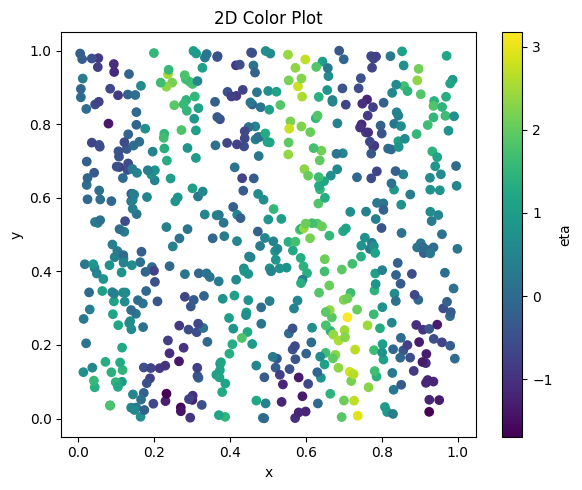

In [3]:
plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

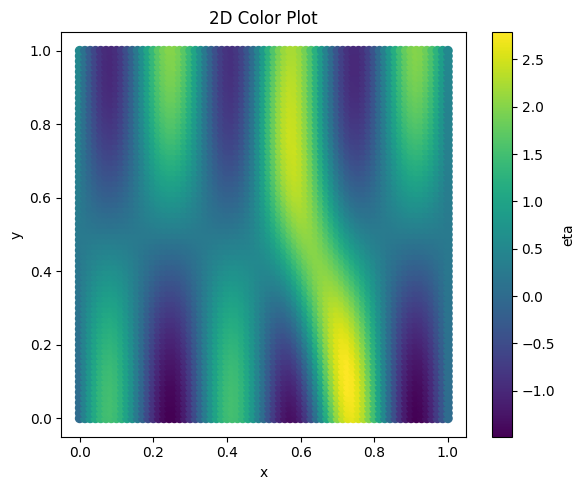

In [4]:
plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [5]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [6]:
import tensorflow_probability.substrates.jax.bijectors as tfb


def scale_fn():
    prior = lsl.Dist(
        tfd.HalfNormal,
        scale=jnp.array(20.0),
    )

    scale = lsl.Var.new_param(
        jnp.array(0.1),
        distribution=prior,
        name="{x}",  # {x} is a placeholder for the automatically generated name
    )

    scale.transform(
        tfb.Softplus(),
        inference=gs.MCMCSpec(gs.IWLSKernel.untuned),
        name="h({x})",  # {x} is a placeholder for the automatically generated name
    )
    return scale


tb = gam.TermBuilder.from_df(df, default_scale_fn=scale_fn)

In [7]:
loc += tb.ps("x", k=15)
loc += tb.ps("y", k=15)


psx = tb.ps("x", k=12)
psy = tb.ps("y", k=12)

loc += tb.tx(psx, psy)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


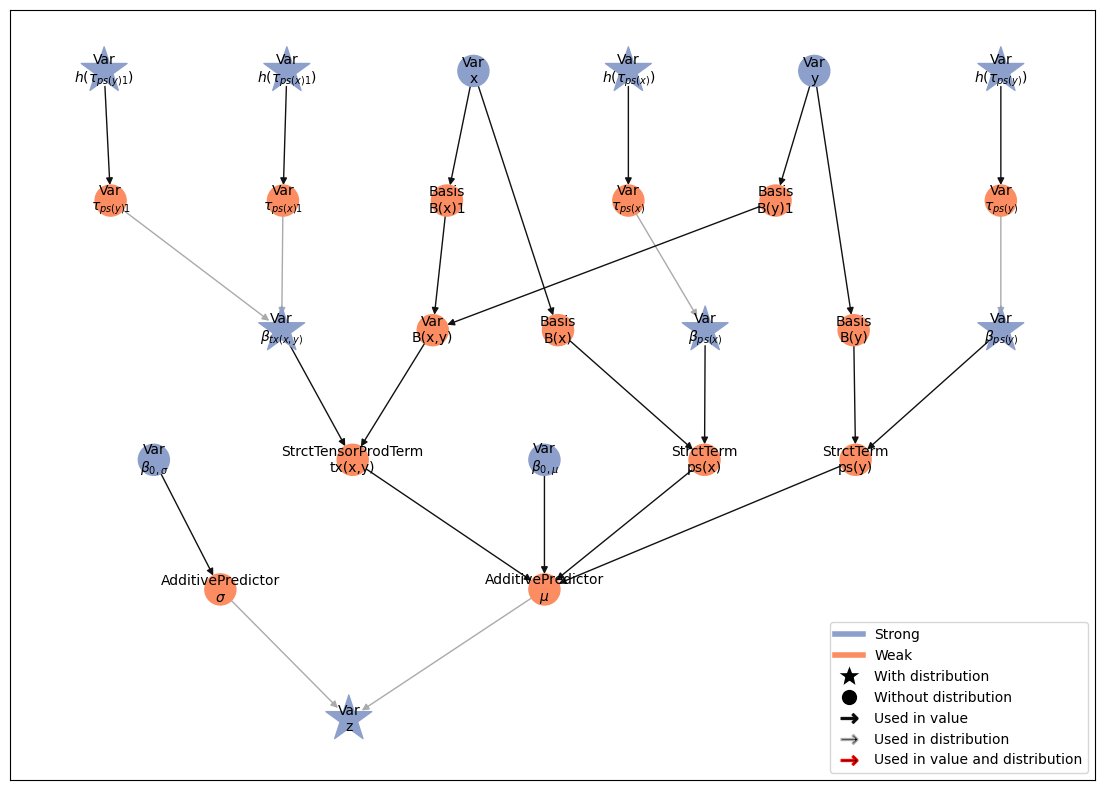

In [8]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

In [9]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(9000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{tx(x,y)}$', '$h(\\tau_{ps(y)1})$', '$h(\\tau_{ps(x)1})$', '$\\beta_{ps(y)}$', '$h(\\tau_{ps(y)})$', '$\\beta_{ps(x)}$', '$h(\\tau_{ps(x)})$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 9000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 9/9 [00:17<00:00,  1.95s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 35, 334, 33, 31 / 9000 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_06: 1, 2, 0, 0 / 9000 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_08: 0, 0, 1, 1 / 9000 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starti

### MCMC summary

In [10]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",3474.404855,3474.404855,3971.892421,3971.892421,1.000077,1.000077
1,"$\beta_{0,\sigma}$",1752.446589,1752.446589,3211.706173,3211.706173,1.001632,1.001632
2,$\beta_{ps(x)}$,2961.800854,3349.946500,3187.134612,3568.053819,1.000867,1.000310
3,$\beta_{ps(y)}$,971.321747,2578.406339,1056.506165,1811.451052,1.009294,1.005722
4,"$\beta_{tx(x,y)}$",300.804955,1468.151829,800.148723,1688.467815,1.026784,1.003717
5,$h(\tau_{ps(x)1})$,2971.149153,2971.149153,2610.390712,2610.390712,1.000495,1.000495
6,$h(\tau_{ps(x)})$,2878.984591,2878.984591,3330.797473,3330.797473,0.999342,0.999342
7,$h(\tau_{ps(y)1})$,150.138651,150.138651,287.366766,287.366766,1.044090,1.044090
8,$h(\tau_{ps(y)})$,404.461391,404.461391,732.995655,732.995655,1.021952,1.021952


In [11]:
summary.error_df()

count sample_size  \
kernel    error_code error_msg           phase                         
kernel_04 90         nan acceptance prob warmup      433       36000   
                                         posterior   158        4000   
kernel_06 90         nan acceptance prob warmup        3       36000   
                                         posterior     0        4000   
kernel_08 90         nan acceptance prob warmup        2       36000   
                                         posterior     0        4000   

                                                   sample_size_total  relative  
kernel    error_code error_msg           phase                                  
kernel_04 90         nan acceptance prob warmup                36000  0.012028  
                                         posterior             40000   0.00395  
kernel_06 90         nan acceptance prob warmup                36000  0.000083  
                                         posterior             40000       0.0  
kernel_08 90         nan acceptance prob warmup                36000  0.000056  
                                         posterior             40000       0.0

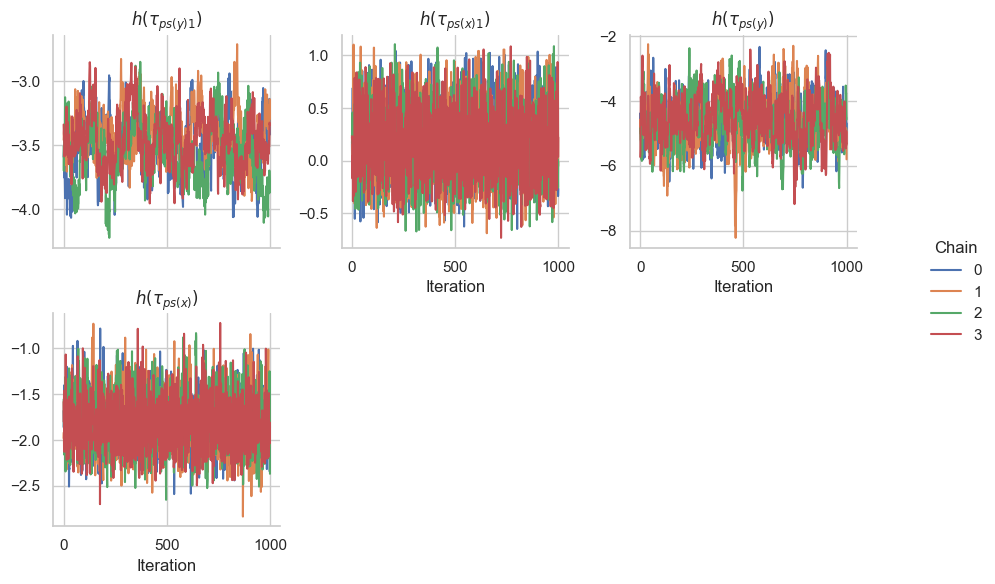

In [12]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n])

In [13]:
samples = results.get_posterior_samples()

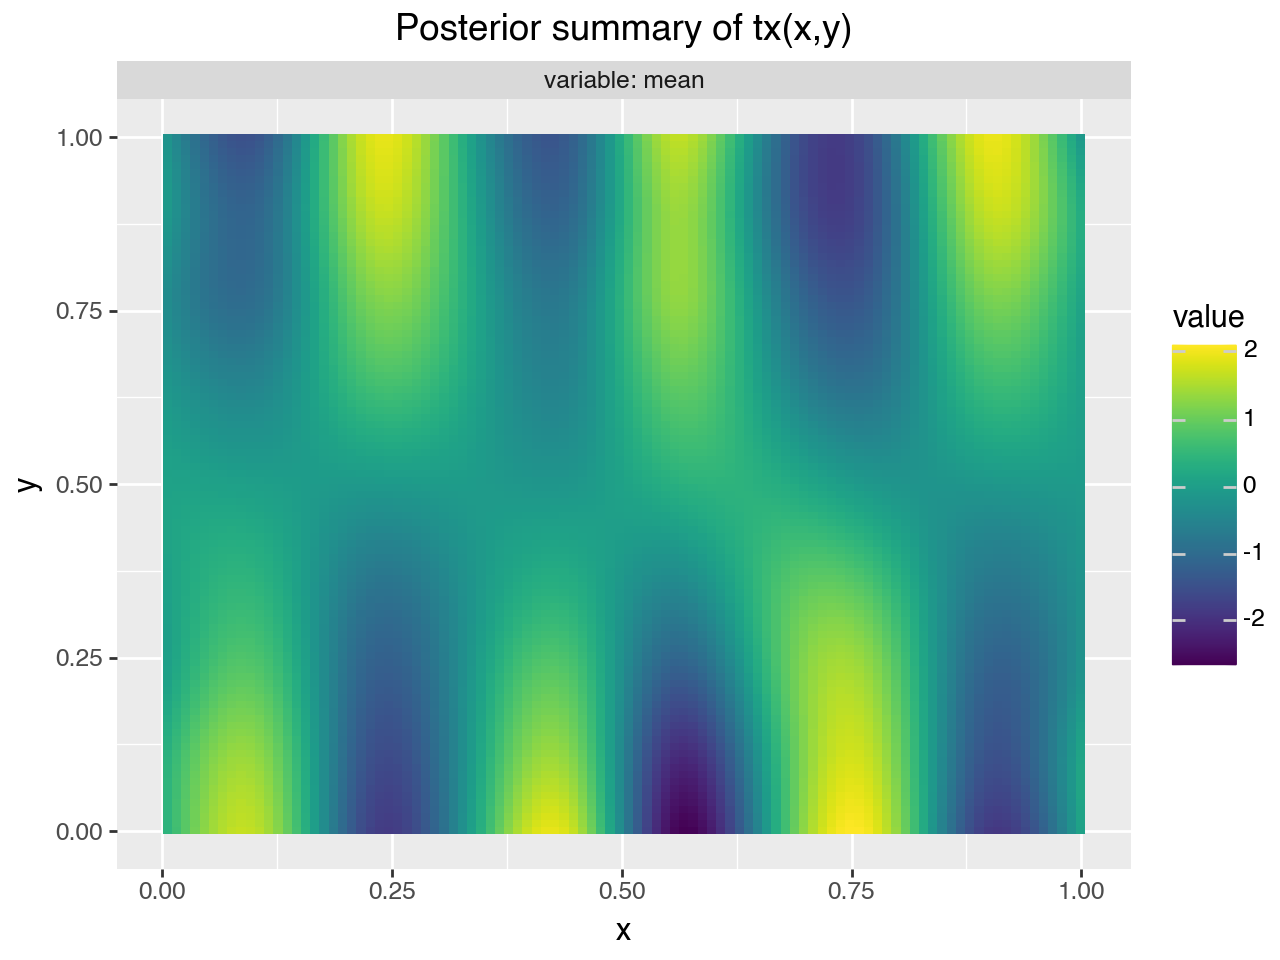

In [14]:
gam.plot_2d_smooth(model.vars["tx(x,y)"], samples, ngrid=100)

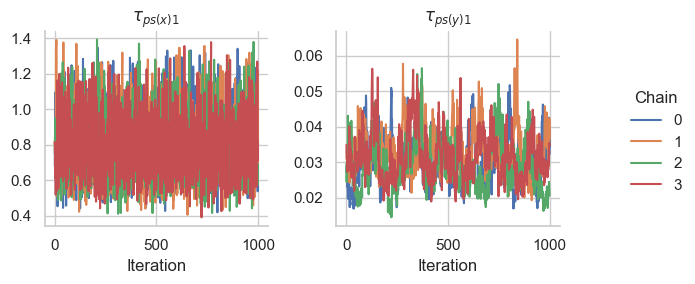

In [15]:
gs.plot_trace(
    model.predict(samples, predict=[s.name for s in model.vars["tx(x,y)"].scales])
)

### MCMC trace plots

## Predictions

In [16]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [17]:
predictions = model.predict(
    samples=samples,
    predict=["$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions, which=["mean", "quantiles"])
    .to_dataframe()
    .reset_index()
)

In [18]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [19]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,q_0.05,q_0.5,q_0.95,x,y
0,$\mu$,$\mu$[0],"(0,)",4000,0.221714,-0.796235,0.216299,1.231756,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",4000,0.587376,-0.198893,0.580743,1.381314,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",4000,0.929080,0.297584,0.928636,1.550423,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",4000,1.229069,0.700319,1.233325,1.742260,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",4000,1.470111,1.023793,1.480602,1.905741,0.057143,0.0


### Plot fitted functions

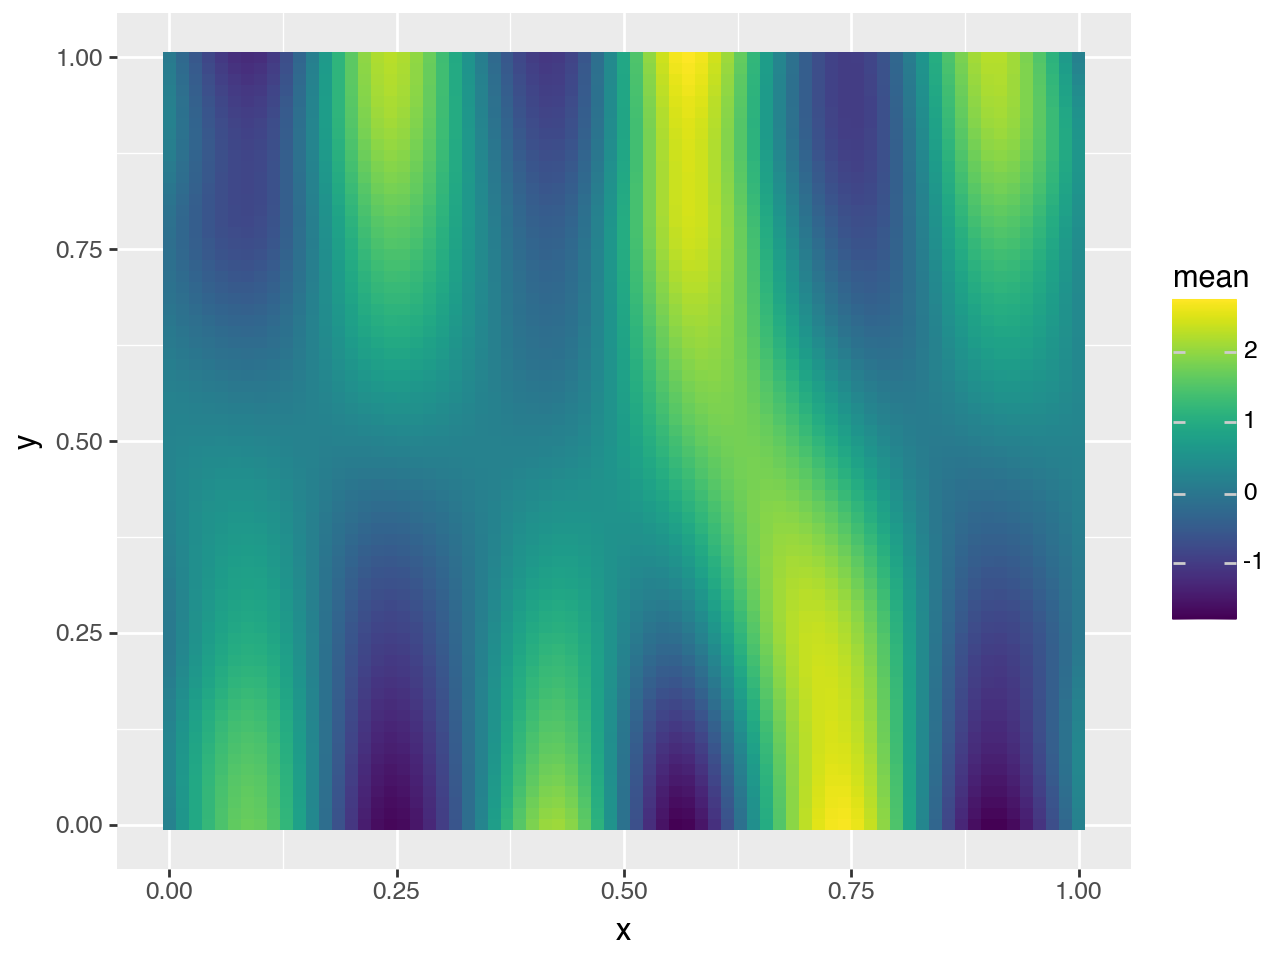

In [21]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

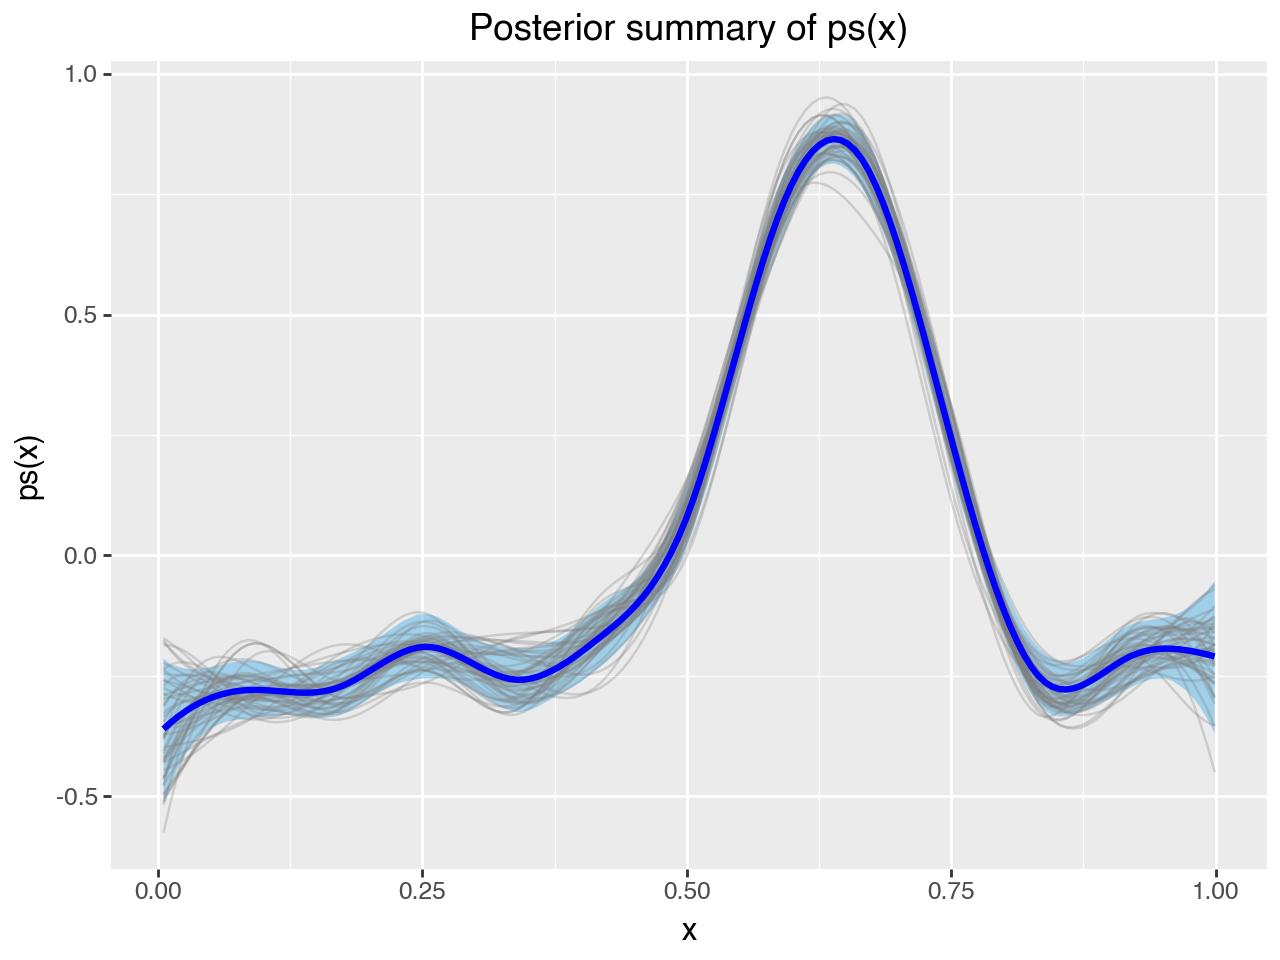

In [22]:
gam.plot_1d_smooth(model.vars["ps(x)"], samples)

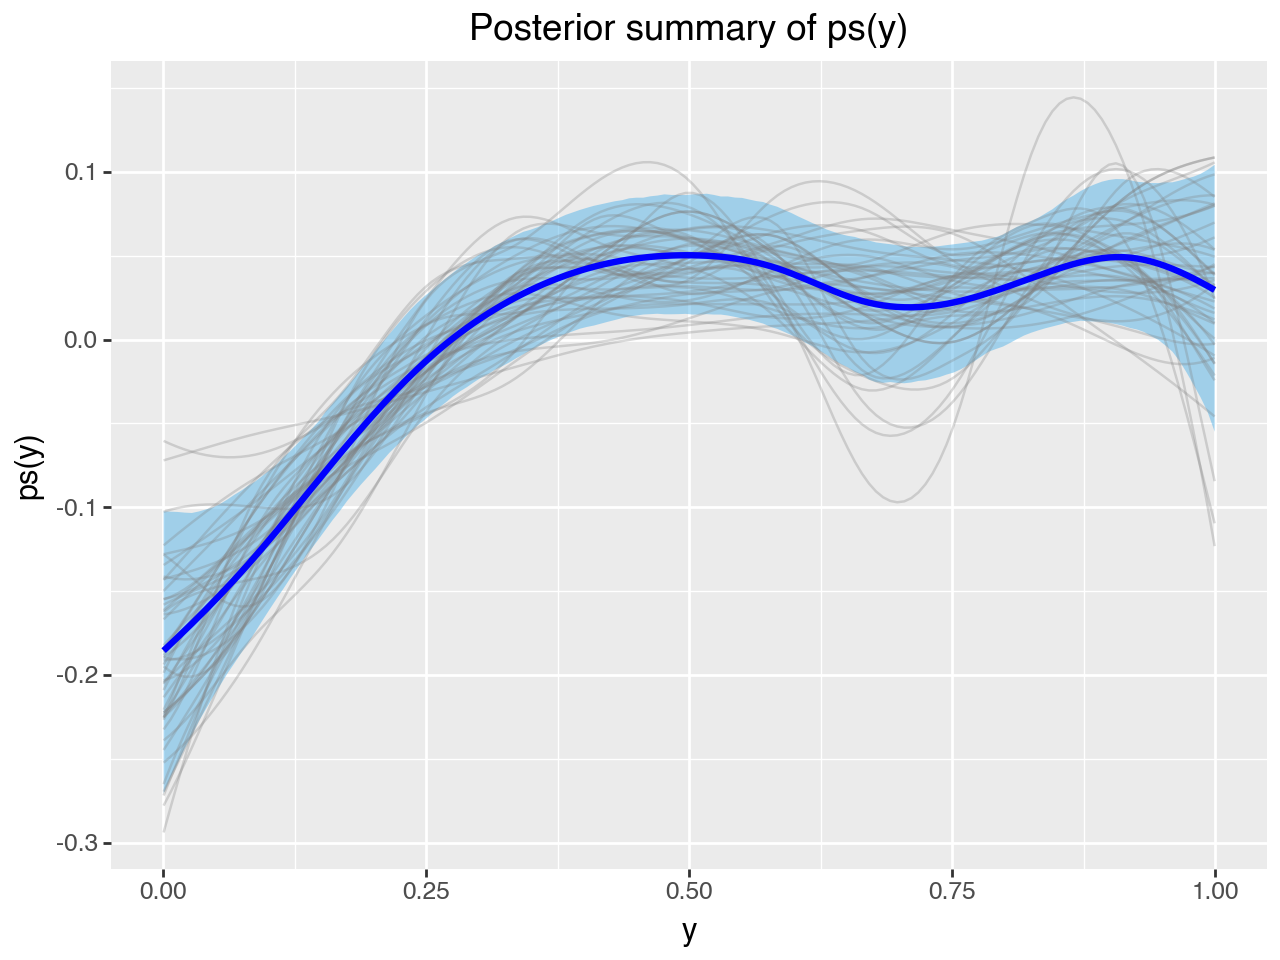

In [23]:
gam.plot_1d_smooth(model.vars["ps(y)"], samples)

In [24]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

PlotnineError: 'Faceting variables must have at least one value'

In [25]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

PlotnineError: 'Faceting variables must have at least one value'